In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from sklearn.metrics import accuracy_score,f1_score,confusion_matrix,classification_report
from sklearn.model_selection import train_test_split,cross_val_score,KFold,StratifiedKFold
from sklearn.linear_model import LogisticRegression
import optuna
from category_encoders import *
from sklearn.pipeline import Pipeline
import warnings
warnings.filterwarnings('ignore')
import pickle
#Get your class weights

from sklearn.utils.class_weight import compute_class_weight
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer as imputer

SEED = 123


%matplotlib inline
sns.set_style('darkgrid')
matplotlib.rcParams["font.size"] = 14
matplotlib.rcParams["figure.figsize"] = (9, 5)
matplotlib.rcParams["figure.facecolor"] = "#00000000"

In [2]:
#load the train and test data


train_demo = pd.read_csv('traindemographics.csv')
train_per = pd.read_csv('trainperf.csv')
train_previous = pd.read_csv('trainprevloans.csv')
train_demo.head(5)



test_demo = pd.read_csv('testdemographics.csv')
test_per = pd.read_csv('testperf.csv')
test_previous = pd.read_csv('testprevloans.csv')
test_demo.head(5)


samplesubmission = pd.read_csv("SampleSubmission.csv")

In [3]:
train_demo.head()

,customerid,birthdate,bank_account_type,longitude_gps,latitude_gps,bank_name_clients,bank_branch_clients,employment_status_clients,level_of_education_clients
0,8a858e135cb22031015cbafc76964ebd,1973-10-10 00:00:00.000000,Savings,3.319219,6.528604,GT Bank,NaN,NaN,NaN
1,8a858e275c7ea5ec015c82482d7c3996,1986-01-21 00:00:00.000000,Savings,3.325598,7.119403,Sterling Bank,NaN,Permanent,NaN
2,8a858e5b5bd99460015bdc95cd485634,1987-04-01 00:00:00.000000,Savings,5.746100,5.563174,Fidelity Bank,NaN,NaN,NaN
3,8a858efd5ca70688015cabd1f1e94b55,1991-07-19 00:00:00.000000,Savings,3.362850,6.642485,GT Bank,NaN,Permanent,NaN
4,8a858e785acd3412015acd48f4920d04,1982-11-22 00:00:00.000000,Savings,8.455332,11.971410,GT Bank,NaN,Permanent,NaN


In [4]:
train_per.head() 

,customerid,systemloanid,loannumber,approveddate,creationdate,loanamount,totaldue,termdays,referredby,good_bad_flag
0,8a2a81a74ce8c05d014cfb32a0da1049,301994762,12,2017-07-25 08:22:56.000000,2017-07-25 07:22:47.000000,30000.0,34500.0,30,NaN,Good
1,8a85886e54beabf90154c0a29ae757c0,301965204,2,2017-07-05 17:04:41.000000,2017-07-05 16:04:18.000000,15000.0,17250.0,30,NaN,Good
2,8a8588f35438fe12015444567666018e,301966580,7,2017-07-06 14:52:57.000000,2017-07-06 13:52:51.000000,20000.0,22250.0,15,NaN,Good
3,8a85890754145ace015429211b513e16,301999343,3,2017-07-27 19:00:41.000000,2017-07-27 18:00:35.000000,10000.0,11500.0,15,NaN,Good
4,8a858970548359cc0154883481981866,301962360,9,2017-07-03 23:42:45.000000,2017-07-03 22:42:39.000000,40000.0,44000.0,30,NaN,Good


In [5]:
train_previous.head()

,customerid,systemloanid,loannumber,approveddate,creationdate,loanamount,totaldue,termdays,closeddate,referredby,firstduedate,firstrepaiddate
0,8a2a81a74ce8c05d014cfb32a0da1049,301682320,2,2016-08-15 18:22:40.000000,2016-08-15 17:22:32.000000,10000.0,13000.0,30,2016-09-01 16:06:48.000000,NaN,2016-09-14 00:00:00.000000,2016-09-01 15:51:43.000000
1,8a2a81a74ce8c05d014cfb32a0da1049,301883808,9,2017-04-28 18:39:07.000000,2017-04-28 17:38:53.000000,10000.0,13000.0,30,2017-05-28 14:44:49.000000,NaN,2017-05-30 00:00:00.000000,2017-05-26 00:00:00.000000
2,8a2a81a74ce8c05d014cfb32a0da1049,301831714,8,2017-03-05 10:56:25.000000,2017-03-05 09:56:19.000000,20000.0,23800.0,30,2017-04-26 22:18:56.000000,NaN,2017-04-04 00:00:00.000000,2017-04-26 22:03:47.000000
3,8a8588f35438fe12015444567666018e,301861541,5,2017-04-09 18:25:55.000000,2017-04-09 17:25:42.000000,10000.0,11500.0,15,2017-04-24 01:35:52.000000,NaN,2017-04-24 00:00:00.000000,2017-04-24 00:48:43.000000
4,8a85890754145ace015429211b513e16,301941754,2,2017-06-17 09:29:57.000000,2017-06-17 08:29:50.000000,10000.0,11500.0,15,2017-07-14 21:18:43.000000,NaN,2017-07-03 00:00:00.000000,2017-07-14 21:08:35.000000


In [6]:
test_demo.head()

,customerid,birthdate,bank_account_type,longitude_gps,latitude_gps,bank_name_clients,bank_branch_clients,employment_status_clients,level_of_education_clients
0,8a858f305c8dd672015c93b1db645db4,1976-08-28 00:00:00.000000,Savings,5.296628,7.593965,Heritage Bank,NaN,Permanent,NaN
1,8a858f085a477386015a47fb049e49ca,1978-06-23 00:00:00.000000,Savings,3.294513,6.596602,UBA,NaN,Permanent,NaN
2,8a858e6f5cd5e874015cd6f5634c39ad,1984-04-04 00:00:00.000000,Savings,8.501912,7.729364,First Bank,NaN,Permanent,NaN
3,8a858e9d5bfd7037015bfdab79f61305,1983-05-28 00:00:00.000000,Savings,3.318904,6.681595,UBA,NaN,Permanent,NaN
4,8a858fde56eb02280156eb6dafc128ac,1982-03-29 00:00:00.000000,Savings,6.354624,4.949031,First Bank,NaN,Self-Employed,NaN


In [7]:
test_per.head() 

,customerid,systemloanid,loannumber,approveddate,creationdate,loanamount,totaldue,termdays,referredby
0,8a858899538ddb8e015390510b321f08,301998974,4,40:48.0,39:35.0,10000,12250.0,30,NaN
1,8a858959537a097401537a4e316e25f7,301963615,10,43:40.0,42:34.0,40000,44000.0,30,NaN
2,8a8589c253ace09b0153af6ba58f1f31,301982236,6,15:11.0,15:04.0,20000,24500.0,30,NaN
3,8a858e095aae82b7015aae86ca1e030b,301971730,8,00:54.0,00:49.0,30000,34500.0,30,NaN
4,8a858e225a28c713015a30db5c48383d,301959177,4,04:33.0,04:27.0,20000,24500.0,30,NaN


In [8]:
train_per.isnull().sum()

customerid          0
systemloanid        0
loannumber          0
approveddate        0
creationdate        0
loanamount          0
totaldue            0
termdays            0
referredby       3781
good_bad_flag       0
dtype: int64

In [9]:
test_per

# train_previous

,customerid,systemloanid,loannumber,approveddate,creationdate,loanamount,totaldue,termdays,referredby
0,8a858899538ddb8e015390510b321f08,301998974,4,40:48.0,39:35.0,10000,12250.0,30,NaN
1,8a858959537a097401537a4e316e25f7,301963615,10,43:40.0,42:34.0,40000,44000.0,30,NaN
2,8a8589c253ace09b0153af6ba58f1f31,301982236,6,15:11.0,15:04.0,20000,24500.0,30,NaN
3,8a858e095aae82b7015aae86ca1e030b,301971730,8,00:54.0,00:49.0,30000,34500.0,30,NaN
4,8a858e225a28c713015a30db5c48383d,301959177,4,04:33.0,04:27.0,20000,24500.0,30,NaN
...,...,...,...,...,...,...,...,...,...
1445,8a858fb45bb59c21015bb88a191f58f2,301991141,3,47:02.0,46:53.0,10000,11500.0,15,NaN
1446,8a858fcb5b00cc54015b0253ced26a5f,301963018,3,00:45.0,04:05.0,10000,13000.0,30,NaN
1447,8a858fde56eb02280156f59b976d46c0,301994653,9,09:40.0,09:33.0,40000,48000.0,60,NaN
1448,8a858e10570f2d65015717fcfec44996,301961483,14,47:54.0,46:49.0,60000,68100.0,90,NaN


In [10]:
#We will be merging the demography data and the performance data together

#We will leave out the previous loan data because its customerid column does not align with the id columns of the performance data although adding it will 
#have been of good importance to our model but we can't because of the issue


data = train_per.merge(train_demo,on='customerid',how='left')


test = test_per.merge(test_demo,on='customerid',how='left')




data.head()




,customerid,systemloanid,loannumber,approveddate,creationdate,loanamount,totaldue,termdays,referredby,good_bad_flag,birthdate,bank_account_type,longitude_gps,latitude_gps,bank_name_clients,bank_branch_clients,employment_status_clients,level_of_education_clients
0,8a2a81a74ce8c05d014cfb32a0da1049,301994762,12,2017-07-25 08:22:56.000000,2017-07-25 07:22:47.000000,30000.0,34500.0,30,NaN,Good,1972-01-15 00:00:00.000000,Other,3.432010,6.433055,Diamond Bank,NaN,Permanent,Post-Graduate
1,8a85886e54beabf90154c0a29ae757c0,301965204,2,2017-07-05 17:04:41.000000,2017-07-05 16:04:18.000000,15000.0,17250.0,30,NaN,Good,1985-08-23 00:00:00.000000,Savings,3.885298,7.320700,GT Bank,"DUGBE,IBADAN",Permanent,Graduate
2,8a8588f35438fe12015444567666018e,301966580,7,2017-07-06 14:52:57.000000,2017-07-06 13:52:51.000000,20000.0,22250.0,15,NaN,Good,1984-09-18 00:00:00.000000,Other,11.139350,10.292041,EcoBank,NaN,Permanent,NaN
3,8a85890754145ace015429211b513e16,301999343,3,2017-07-27 19:00:41.000000,2017-07-27 18:00:35.000000,10000.0,11500.0,15,NaN,Good,1977-10-10 00:00:00.000000,Savings,3.985770,7.491708,First Bank,NaN,Permanent,NaN
4,8a858970548359cc0154883481981866,301962360,9,2017-07-03 23:42:45.000000,2017-07-03 22:42:39.000000,40000.0,44000.0,30,NaN,Good,1986-09-07 00:00:00.000000,Other,7.457913,9.076574,GT Bank,NaN,Permanent,Primary


In [11]:
test.head()

,customerid,systemloanid,loannumber,approveddate,creationdate,loanamount,totaldue,termdays,referredby,birthdate,bank_account_type,longitude_gps,latitude_gps,bank_name_clients,bank_branch_clients,employment_status_clients,level_of_education_clients
0,8a858899538ddb8e015390510b321f08,301998974,4,40:48.0,39:35.0,10000,12250.0,30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,8a858959537a097401537a4e316e25f7,301963615,10,43:40.0,42:34.0,40000,44000.0,30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,8a8589c253ace09b0153af6ba58f1f31,301982236,6,15:11.0,15:04.0,20000,24500.0,30,NaN,1981-09-05 00:00:00.000000,Savings,3.227945,6.586668,UBA,NaN,Permanent,NaN
3,8a858e095aae82b7015aae86ca1e030b,301971730,8,00:54.0,00:49.0,30000,34500.0,30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,8a858e225a28c713015a30db5c48383d,301959177,4,04:33.0,04:27.0,20000,24500.0,30,NaN,1975-08-25 00:00:00.000000,Savings,5.248368,13.059864,UBA,NaN,Permanent,NaN


In [12]:
#we will be dropping this columns because they contain a lot of null values
data = data.drop(['level_of_education_clients','bank_branch_clients','referredby'],1)

test = test.drop(['level_of_education_clients','bank_branch_clients','referredby'],1)



data = data.drop(['customerid','systemloanid'],1)
test = test.drop(['customerid','systemloanid'],1)

test.head()

,loannumber,approveddate,creationdate,loanamount,totaldue,termdays,birthdate,bank_account_type,longitude_gps,latitude_gps,bank_name_clients,employment_status_clients
0,4,40:48.0,39:35.0,10000,12250.0,30,NaN,NaN,NaN,NaN,NaN,NaN
1,10,43:40.0,42:34.0,40000,44000.0,30,NaN,NaN,NaN,NaN,NaN,NaN
2,6,15:11.0,15:04.0,20000,24500.0,30,1981-09-05 00:00:00.000000,Savings,3.227945,6.586668,UBA,Permanent
3,8,00:54.0,00:49.0,30000,34500.0,30,NaN,NaN,NaN,NaN,NaN,NaN
4,4,04:33.0,04:27.0,20000,24500.0,30,1975-08-25 00:00:00.000000,Savings,5.248368,13.059864,UBA,Permanent


In [13]:
data.employment_status_clients.unique()

array(['Permanent', nan, 'Unemployed', 'Self-Employed', 'Student',
       'Retired', 'Contract'], dtype=object)

### Exploratory Data Analysis

Good    0.782221
Bad     0.217779
Name: good_bad_flag, dtype: float64


Text(0.5, 1.0, 'Good bad count')

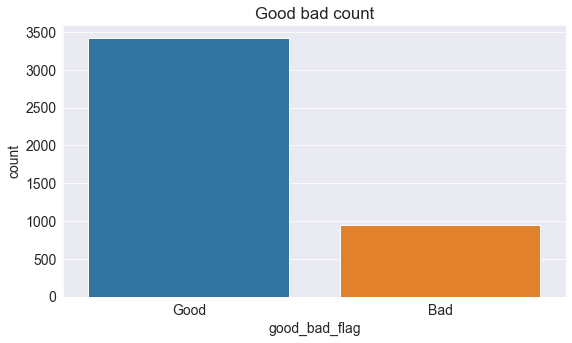

In [14]:
#proportion of customers with good and bad flag

print(data.good_bad_flag.value_counts(normalize=True))
sns.countplot(x='good_bad_flag',data=data)
plt.title('Good bad count')

loanamount  good_bad_flag
10000.0     Good             0.734198
            Bad              0.265802
15000.0     Good             0.865854
            Bad              0.134146
20000.0     Good             0.837388
            Bad              0.162612
25000.0     Good             0.870968
            Bad              0.129032
30000.0     Good             0.835616
            Bad              0.164384
35000.0     Good             0.900000
            Bad              0.100000
40000.0     Good             0.862275
            Bad              0.137725
45000.0     Good             1.000000
50000.0     Good             0.857143
            Bad              0.142857
60000.0     Good             0.875000
            Bad              0.125000
Name: good_bad_flag, dtype: float64


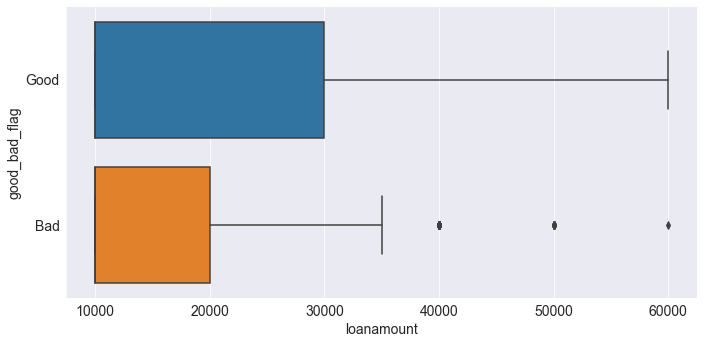

In [15]:
#distribution of the amount of loan people colect

g = data.groupby('loanamount')['good_bad_flag'].value_counts(normalize=True)  

print(g)

sns.catplot(x ='loanamount',y='good_bad_flag',data = data,kind='box',aspect=2)

Most defaulters collected loans between 10 thousand and 35 thousand


<AxesSubplot:title={'center':'Bank account types'}, xlabel='bank_account_type', ylabel='count'>

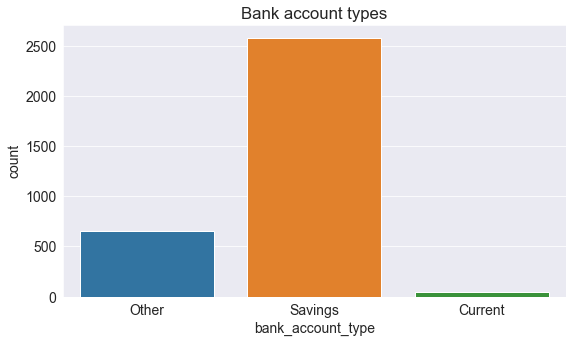

In [16]:
#distribution of the amount of banktypes

plt.title('Bank account types');
sns.countplot(data['bank_account_type'])

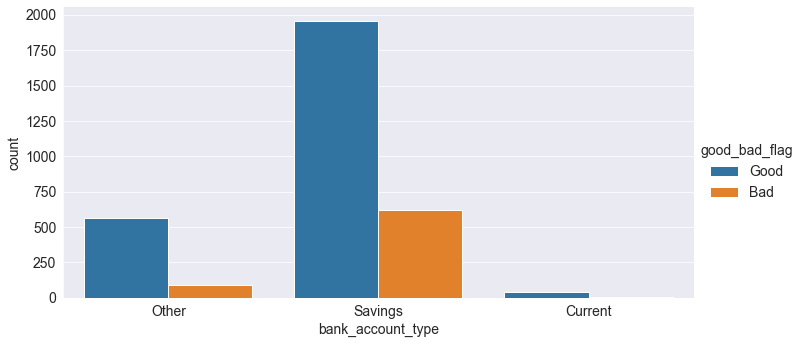

In [17]:
#distribution of the type of account with their defaulting rates
sns.catplot(x='bank_account_type',data=data,hue='good_bad_flag',kind='count',aspect=2)


Good    0.759116
Bad     0.240884
Name: good_bad_flag, dtype: float64


Text(0.5, 1.0, 'Savings with good bad flag')

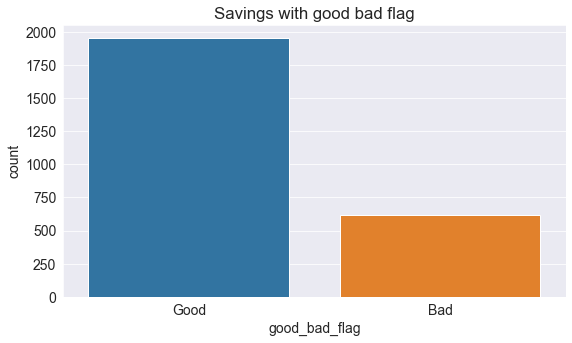

In [18]:
acc_dat = data[data['bank_account_type'] == 'Savings']['good_bad_flag']
print(acc_dat.value_counts(normalize=True))
sns.countplot(acc_dat)
plt.title("Savings with good bad flag")

Good    0.891304
Bad     0.108696
Name: good_bad_flag, dtype: float64


Text(0.5, 1.0, 'Current with good bad flag')

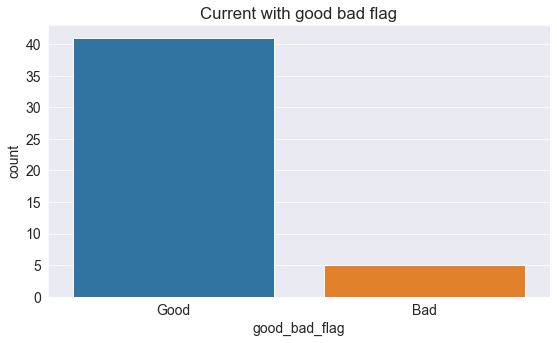

In [19]:
acc_cur = data[data['bank_account_type'] == 'Current']['good_bad_flag']
print(acc_cur.value_counts(normalize=True))
sns.countplot(acc_cur)
plt.title("Current with good bad flag")

From the plot, we can see that most customers opened the savings account with only few people opening current account 

<AxesSubplot:title={'center':'Customers Employment status'}, xlabel='employment_status_clients', ylabel='count'>

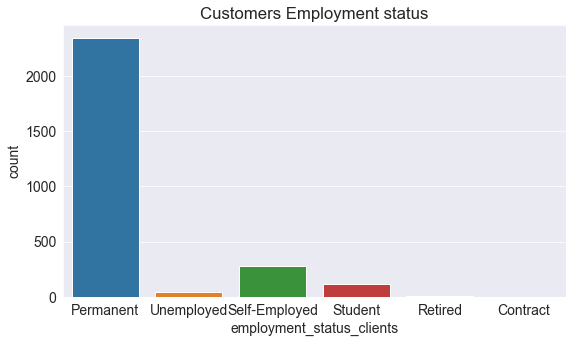

In [20]:
#distribution of the amount of banktypes

plt.title('Customers Employment status');
sns.countplot(data['employment_status_clients'])

Most of their customers are parmanently employed with a few of them unemployed

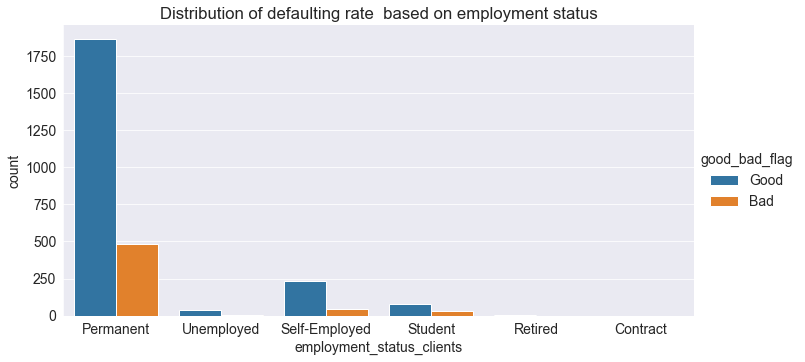

In [21]:
sns.catplot(x='employment_status_clients' ,data=data,hue='good_bad_flag',kind ='count',aspect=2)

plt.title('Distribution of defaulting rate  based on employment status');

Good    0.794719
Bad     0.205281
Name: good_bad_flag, dtype: float64


Text(0.5, 1.0, 'Parmanent with good bad flag')

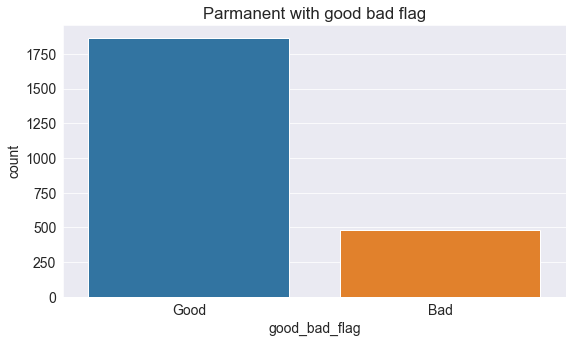

In [22]:
acc_dat = data[data['employment_status_clients'] == 'Permanent']['good_bad_flag']
print(acc_dat.value_counts(normalize=True))
sns.countplot(acc_dat)
plt.title("Parmanent with good bad flag")

Good    0.837209
Bad     0.162791
Name: good_bad_flag, dtype: float64


Text(0.5, 1.0, 'Unemployed with good bad flag')

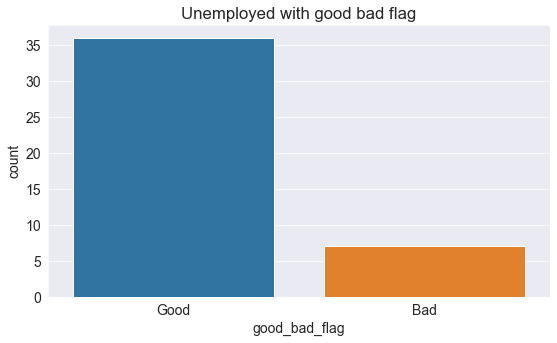

In [23]:
acc_dat = data[data['employment_status_clients'] == 'Unemployed']['good_bad_flag']
print(acc_dat.value_counts(normalize=True))
sns.countplot(acc_dat)
plt.title("Unemployed with good bad flag")

Good    0.72973
Bad     0.27027
Name: good_bad_flag, dtype: float64


Text(0.5, 1.0, 'Student with good bad flag')

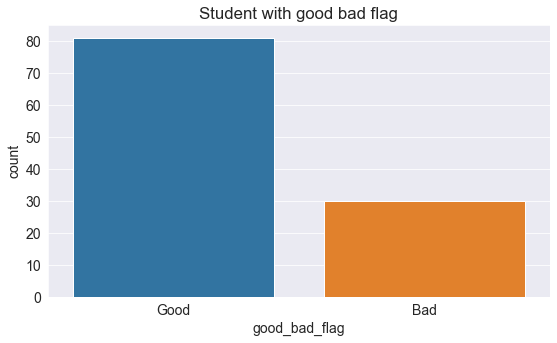

In [24]:
acc_dat = data[data['employment_status_clients'] == 'Student']['good_bad_flag']
print(acc_dat.value_counts(normalize=True))
sns.countplot(acc_dat)
plt.title("Student with good bad flag")

Good    0.837545
Bad     0.162455
Name: good_bad_flag, dtype: float64


Text(0.5, 1.0, 'Self-Employed with good bad flag')

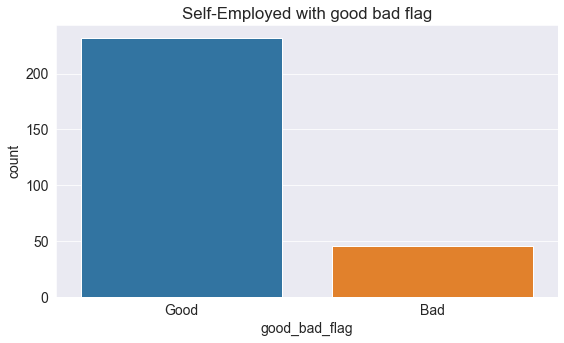

In [25]:
acc_dat = data[data['employment_status_clients'] == 'Self-Employed']['good_bad_flag']
print(acc_dat.value_counts(normalize=True))
sns.countplot(acc_dat)
plt.title("Self-Employed with good bad flag")

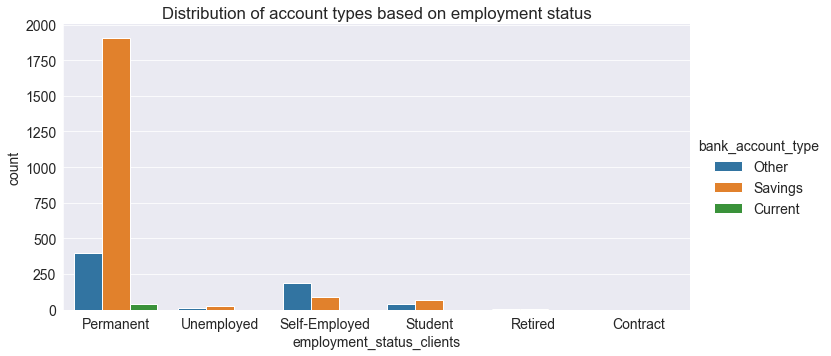

In [26]:
sns.catplot(x='employment_status_clients' ,data=data,hue='bank_account_type',kind ='count',aspect=2)

plt.title('Distribution of account types based on employment status');

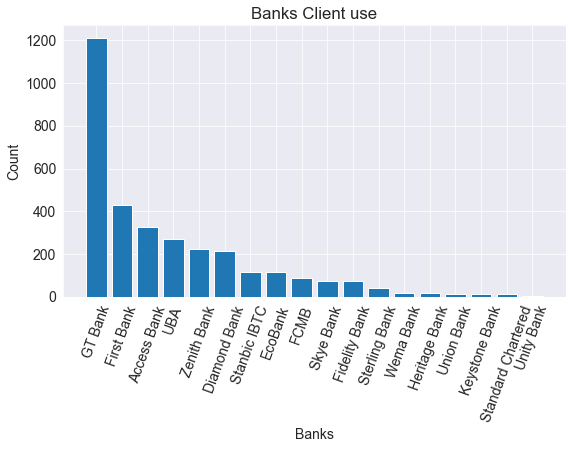

In [27]:
b_n = data['bank_name_clients'].value_counts(ascending=False).reset_index()

plt.bar(height=b_n['bank_name_clients'], x= b_n['index'])
plt.title('Banks Client use')
plt.xlabel('Banks')
plt.ylabel('Count')
plt.xticks(rotation=70);

# b_n 

##### Most of their customers used Gtb bank

In [28]:
g = data.groupby('bank_name_clients')['good_bad_flag'].value_counts(normalize=True)  
g

bank_name_clients   good_bad_flag
Access Bank         Good             0.762918
                    Bad              0.237082
Diamond Bank        Good             0.856481
                    Bad              0.143519
EcoBank             Good             0.741379
                    Bad              0.258621
FCMB                Good             0.741573
                    Bad              0.258427
Fidelity Bank       Good             0.770270
                    Bad              0.229730
First Bank          Good             0.779070
                    Bad              0.220930
GT Bank             Good             0.784298
                    Bad              0.215702
Heritage Bank       Good             0.833333
                    Bad              0.166667
Keystone Bank       Good             0.785714
                    Bad              0.214286
Skye Bank           Good             0.710526
                    Bad              0.289474
Stanbic IBTC        Good             0.846154


Only about a quater had a bad flag while the rest had a good flag

### Feature Engineering

In [29]:
#fill in null vaues

data.isnull().sum()

loannumber                      0
approveddate                    0
creationdate                    0
loanamount                      0
totaldue                        0
termdays                        0
good_bad_flag                   0
birthdate                    1099
bank_account_type            1099
longitude_gps                1099
latitude_gps                 1099
bank_name_clients            1099
employment_status_clients    1592
dtype: int64

In [30]:
test.isnull().sum()

loannumber                      0
approveddate                    0
creationdate                    0
loanamount                      0
totaldue                        0
termdays                        0
birthdate                    1065
bank_account_type            1065
longitude_gps                1065
latitude_gps                 1065
bank_name_clients            1065
employment_status_clients    1118
dtype: int64

In [31]:
#feature engineering of the dates    	 

data['approveddate'] = pd.to_datetime(data['approveddate'])
data['birthdate'] = pd.to_datetime(data['birthdate'])
data['creationdate'] = pd.to_datetime(data['creationdate'])




test['approveddate'] = pd.to_datetime(test['approveddate'],errors='coerce')
test['birthdate'] = pd.to_datetime(test['birthdate'],errors='coerce')
test['creationdate'] = pd.to_datetime(test['creationdate'],errors='coerce')



# Extract date features
def extract_date_info(df,cols):
    for feat in cols:
        df[feat +'_year'] = df[feat].dt.year        
        df[feat +'_day'] = df[feat].dt.day
        df[feat +'_month'] = df[feat].dt.month
        df[feat +'_quarter'] = df[feat].dt.quarter  
        df[feat +'_weekday'] = df[feat].dt.weekday
        df[feat +'_hour'] = df[feat].dt.hour
        df[feat +'_minute'] = df[feat].dt.minute
        df[feat +'_second'] = df[feat].dt.second
        
        
extract_date_info(data,['approveddate'])
extract_date_info(data,['birthdate'])
extract_date_info(data,['creationdate'])


extract_date_info(test,['approveddate'])
extract_date_info(test,['birthdate'])
extract_date_info(test,['creationdate'])



data = data.drop(['approveddate','birthdate', 'creationdate'],1)
test = test.drop(['approveddate','birthdate', 'creationdate'],1)


# max(data['creationdate'])

In [32]:
data = data.drop(['birthdate_hour','birthdate_minute', 'birthdate_second'],1)
test = test.drop(['birthdate_hour','birthdate_minute', 'birthdate_second'],1)

print(test.shape)

print(data.shape)

(1450, 30)
(4376, 31)


In [33]:
t_target = data['good_bad_flag'].map({'Good':1,'Bad':0})

t_data = data.drop('good_bad_flag',1)



In [34]:
t_data.isnull().sum()

loannumber                      0
loanamount                      0
totaldue                        0
termdays                        0
bank_account_type            1099
longitude_gps                1099
latitude_gps                 1099
bank_name_clients            1099
employment_status_clients    1592
approveddate_year               0
approveddate_day                0
approveddate_month              0
approveddate_quarter            0
approveddate_weekday            0
approveddate_hour               0
approveddate_minute             0
approveddate_second             0
birthdate_year               1099
birthdate_day                1099
birthdate_month              1099
birthdate_quarter            1099
birthdate_weekday            1099
creationdate_year               0
creationdate_day                0
creationdate_month              0
creationdate_quarter            0
creationdate_weekday            0
creationdate_hour               0
creationdate_minute             0
creationdate_s

In [35]:
test.columns

Index(['loannumber', 'loanamount', 'totaldue', 'termdays', 'bank_account_type',
       'longitude_gps', 'latitude_gps', 'bank_name_clients',
       'employment_status_clients', 'approveddate_year', 'approveddate_day',
       'approveddate_month', 'approveddate_quarter', 'approveddate_weekday',
       'approveddate_hour', 'approveddate_minute', 'approveddate_second',
       'birthdate_year', 'birthdate_day', 'birthdate_month',
       'birthdate_quarter', 'birthdate_weekday', 'creationdate_year',
       'creationdate_day', 'creationdate_month', 'creationdate_quarter',
       'creationdate_weekday', 'creationdate_hour', 'creationdate_minute',
       'creationdate_second'],
      dtype='object')

## Model building

In [36]:

#split your data into train and test
train_x, test_x, train_y, test_y = train_test_split(t_data, t_target,stratify= t_target, test_size=0.2,
                                                    random_state=SEED)
      
#Converts the categorical variables in numeric
ordin = OrdinalEncoder(cols=t_data[['bank_account_type','bank_name_clients','employment_status_clients']])
   
#fills in any missing data using the median of the data distribution  
Imputer = imputer(strategy='median')

#hyperparameters of the machine learning model
param = {'ccp_alpha': 0.00109090909090909, 'class_weight': 'balanced'}

#instantiate the random forest machine learning model
randomforest = RandomForestClassifier(**param,random_state=SEED)
Logistic = LogisticRegression(class_weight='balanced',random_state=SEED)



In [37]:
#pipeline for random_forest
step = [ ('encoder',  ordin),('imputer', Imputer), ('random forest', randomforest)]
pipeline = Pipeline(step)
pipeline = pipeline.fit(train_x,train_y)
preds = pipeline.predict(test_x)

#pipeline for logistic regression
step1 = [ ('encoder',  ordin),('imputer', Imputer), ('Logistic', Logistic)]
pipeline1 = Pipeline(step1)
pipeline1 = pipeline1.fit(train_x,train_y)
pred_log = pipeline1.predict(train_x)
pred_Logistic = pipeline1.predict(test_x)

randomforest_accuracy  = f1_score(test_y,preds)
Logistic_accuracy  = f1_score(test_y,pred_Logistic)

print('random_forest accuracy : ', randomforest_accuracy, '\t')
print('Logistic accuracy :',Logistic_accuracy) 

Light accuracy :  0.8380427291523087 	
Logistic accuracy : 0.6105072463768116


<AxesSubplot:xlabel='good_bad_flag', ylabel='Density'>

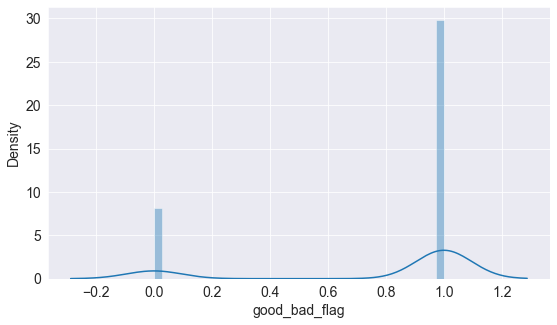

In [38]:
predictions = pipeline.predict(test)

# # Create a submission file

samplesubmission['good_bad_flag'] = predictions


#write to csv file
samplesubmission.to_csv("firstline.csv", index = False)

t = samplesubmission['good_bad_flag']

sns.distplot(t)


### Feature Importance

Text(0.5, 1.0, 'Model features importance:')

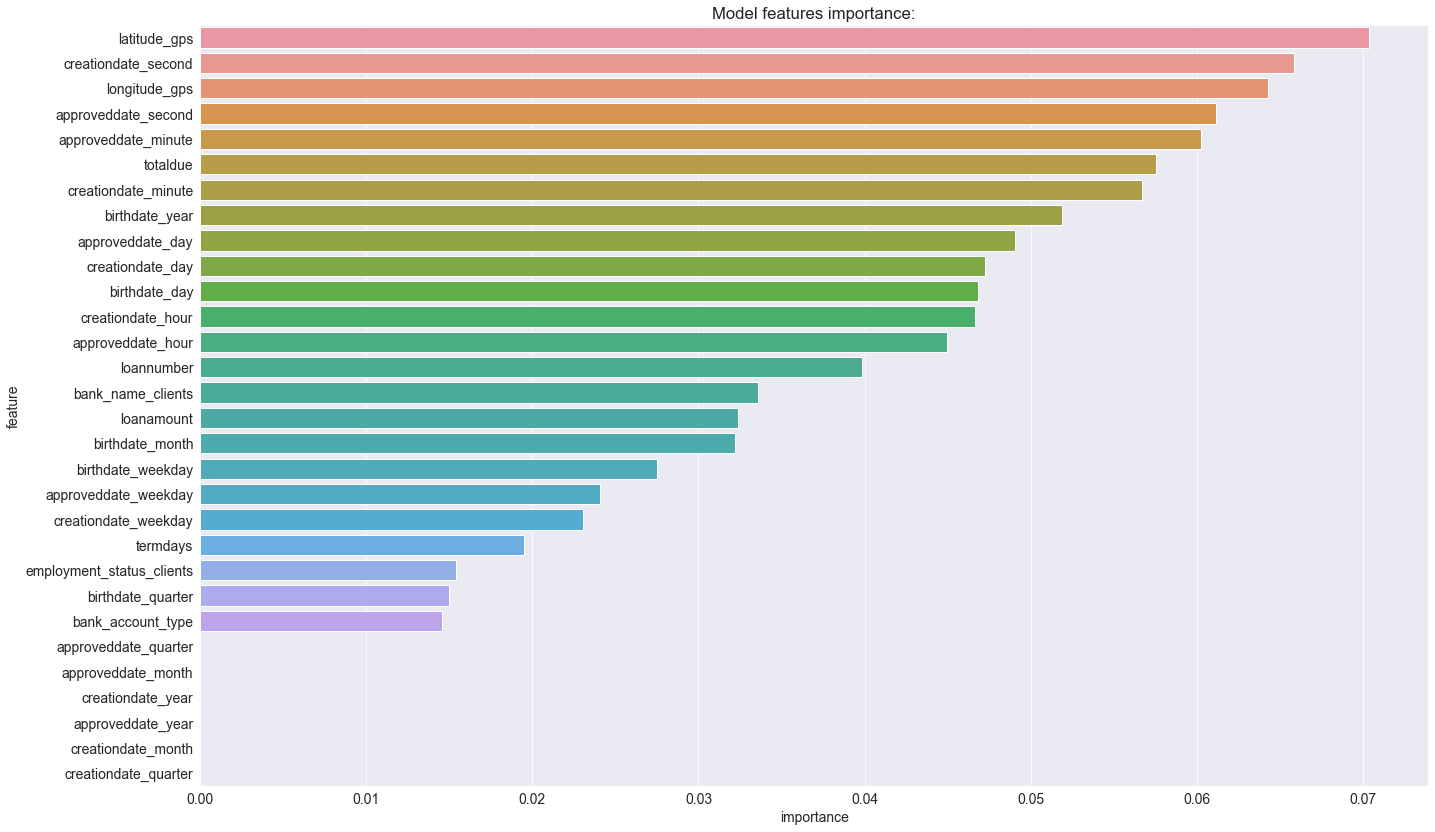

In [44]:
feature_importance_df = pd.DataFrame(randomforest.feature_importances_, columns=['importance'])
feature_importance_df['feature'] = train_x.columns

plt.figure(figsize=(22, 14));
sns.barplot(x="importance", y="feature", data=feature_importance_df.sort_values(by = ['importance'], ascending = False))
plt.title('Model features importance:')

In [40]:
filename = 'loan_model.sav'
with open(filename,'wb') as ft:
    pickle.dump(pipeline, ft)